# Sampling of Decayed Positrons Distribution from Michel Spectrum

<img src="img/big_picture.png" >
<img src="img/pseudo_code.png" >

# 0.0 Setup

In [1]:
import os,shutil
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt

from PositronDecay import GenerateMichelKinematics, GeneratePositron_MRF, Calculate_Phase, GeneratePositron_LAB
from Constants import EMMU, EMASS, pi, twopi, fine_structure_const

Welcome to JupyROOT 6.24/00


In [2]:
# setting
N_positrons = 100000 # the number of sample you want
nick_name = "test" # nick name to be given to the dataset
data_path = './data_{}'.format(nick_name)


if os.path.isdir(data_path):
    shutil.rmtree(data_path)
    os.mkdir(data_path)

else:
    os.mkdir(data_path)

# 1.0 Sample the michel distribution of positrons (in the muon frame) over $x$ and $\theta$ by accept-or-reject method
## adapted from Geant4, with Radiative correction

### References: 

general michel parameters:

https://en.wikipedia.org/wiki/Michel_parameters

measuring michel parameters (TWIST)

https://sci-hub.mksa.top/10.1103/PhysRevLett.106.041804

https://slidetodoc.com/measuring-muon-decay-with-twist-glen-marshall-for/


michel sampling implementation in geant 4:

https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/particles/management/src/G4MuonDecayChannelWithSpin.cc

In [3]:
Michel_Samples = np.zeros(shape=(N_positrons,2)) # store samples

for i in range(N_positrons):
    Michel_Samples[i] = GenerateMichelKinematics()

In [4]:
fname = os.path.join(data_path,'01_michel_samples.npy')
np.save(fname,Michel_Samples)

# 2.0 sampling positron 3-momentum (in Muon rest frame)
note: This part is using angles $\theta_s, \theta_c$ from uniformly distributed random number

<img src="img/geometry.png" >

In [5]:
# store posiInitE, posiInitPX, posiInitPY ,posiInitPZ (in MRF),muDecayPolX, muDecayPolY muDecayPolZ
four_momenta_mu_frame = np.zeros(shape=(N_positrons,7)) 

for i in range(N_positrons):
    rndm_theta_s = twopi * np.random.uniform(0,1)
    four_momenta_mu_frame[i] = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s=rndm_theta_s)

In [6]:
fname = os.path.join(data_path,'02_four_momenta_MRF.npy')
np.save(fname,four_momenta_mu_frame)

# 3.0 lorentz boost in pz direction (to LAB frame)

using the implementation of the following formula:
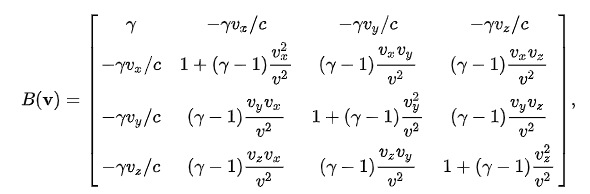

In [7]:
# take MRF results and boost to LAB frame
four_momenta_LAB = np.zeros(shape=(N_positrons,12))
# store the following final variables
#     four_momenta_LAB[i,0] = PosiInitE
#     four_momenta_LAB[i,1] = PosiInitPX
#     four_momenta_LAB[i,2] = PosiInitPY
#     four_momenta_LAB[i,3] = PosiInitPZ
#     four_momenta_LAB[i,4] = muDecayPX
#     four_momenta_LAB[i,5] = muDecayPY
#     four_momenta_LAB[i,6] = muDecayPZ
#     four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolX
#     four_momenta_LAB[:,8] = four_momenta_mu_frame[:,6] # muDecayPolY
#     four_momenta_LAB[:,9] = four_momenta_mu_frame[:,7] # muDecayPolZ  
#     four_momenta_LAB[i,10] = phase # g2phase
#     four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  

for i in range(N_positrons):
    E_primed = four_momenta_mu_frame[i,0]
    px_primed = four_momenta_mu_frame[i,1]
    py_primed = four_momenta_mu_frame[i,2]
    pz_primed = four_momenta_mu_frame[i,3]
    muDecayPolX = four_momenta_mu_frame[i,4]
    muDecayPolY = four_momenta_mu_frame[i,5]
    muDecayPolZ = four_momenta_mu_frame[i,6]
    
    # get positrons in LAB
    rndm_theta_c = twopi * np.random.uniform(0,1)
    four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, rndm_theta_c)
    four_momenta_LAB[:,7] = muDecayPolX
    four_momenta_LAB[:,8] = muDecayPolY
    four_momenta_LAB[:,9] = muDecayPolZ  
    
    # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
    phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                            four_momenta_LAB[i,7], four_momenta_LAB[i,9])
    four_momenta_LAB[i,10] = phase # g2phase
    four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  

In [8]:
fname = os.path.join(data_path,'03_four_momenta_LAB.npy')
np.save(fname,four_momenta_LAB)

# xmau
# all-in-one step: putting all together and test the final output
note: the final result cant be combined with separate MRF result to do plots, because they are uncorrelated !

In [9]:
four_momenta_LAB = np.zeros(shape=(N_positrons,12))
# store the following final variables
#     four_momenta_LAB[i,0] = PosiInitE
#     four_momenta_LAB[i,1] = PosiInitPX
#     four_momenta_LAB[i,2] = PosiInitPY
#     four_momenta_LAB[i,3] = PosiInitPZ
#     four_momenta_LAB[i,4] = muDecayPX
#     four_momenta_LAB[i,5] = muDecayPY
#     four_momenta_LAB[i,6] = muDecayPZ
#     four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolX
#     four_momenta_LAB[:,8] = four_momenta_mu_frame[:,6] # muDecayPolY
#     four_momenta_LAB[:,9] = four_momenta_mu_frame[:,7] # muDecayPolZ  
#     four_momenta_LAB[i,10] = phase # g2phase
#     four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  

for i in range(N_positrons):
    # get positrons in MRF
    rndm_theta_s = twopi * np.random.uniform(0,1)
    E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolY, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),rndm_theta_s)
    
    # get positrons in LAB
    rndm_theta_c = twopi * np.random.uniform(0,1)
    four_momenta_LAB[i,0:7] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, rndm_theta_c)
    four_momenta_LAB[:,7] = muDecayPolX
    four_momenta_LAB[:,8] = muDecayPolY
    four_momenta_LAB[:,9] = muDecayPolZ  
    
    # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
    phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,6],
                            four_momenta_LAB[i,7], four_momenta_LAB[i,9])
    four_momenta_LAB[i,10] = phase # g2phase
    four_momenta_LAB[i,11] = np.cos(phase) # cos(g2phase)  